In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import warnings

import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

import cv2
from PIL import Image
from matplotlib import pyplot as plt 
import os
import sys
import warnings

import torch
import torch.nn as nn
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

import sys
import warnings
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pylab as pl
import seaborn as sns

from torch.cuda.amp import autocast


In [5]:
def load_data(path = "../input/fer2013/fer2013.csv"):
    fer = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer, emotion_mapping

In [6]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample

In [8]:
def tf1(crops):
    return torch.stack([transforms.ToTensor()(crop) for crop in crops])

In [9]:
def tf2(tensors):
    return torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])

In [10]:
def tf3(tensors):
    return torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])

In [11]:
mu, st = 0, 255

In [12]:
def get_dataloaders(bs=64, augment=True):
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation

        input: path to fer2013 csv file
        output: (Dataloader, Dataloader, Dataloader) """

    fer2013, emotion_mapping = load_data(path="../input/fer2013/fer2013.csv")

    xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
    xval, yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
    xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])
    mu, st = 0, 255

    test_transform = transforms.Compose([
        # transforms.Scale(52),
        transforms.TenCrop(40),
        transforms.Lambda(tf1),
        transforms.Lambda(tf2),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

            transforms.TenCrop(40),
            transforms.Lambda(tf1),
            transforms.Lambda(tf2),
            transforms.Lambda(tf3),
        ])
    else:
        train_transform = test_transform

    # X = np.vstack((xtrain, xval))
    # Y = np.hstack((ytrain, yval))

    train = CustomDataset(xtrain, ytrain, train_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=bs, shuffle=False, num_workers=0)
    valloader = DataLoader(val, batch_size=64, shuffle=False, num_workers=0)
    testloader = DataLoader(test, batch_size=64, shuffle=False, num_workers=0)

    return trainloader, valloader, testloader

In [13]:
trainloader, valloader, testloader = get_dataloaders(bs=64)

In [14]:
enumerate(trainloader)

In [15]:
for batch_idx, (feature_data,labels) in enumerate(trainloader):
    for items in feature_data:
        print(items)
    items = feature_data
    labels = labels
    break

tensor([[[[0.2235, 0.2471, 0.3121,  ..., 0.3108, 0.2268, 0.2235],
          [0.2272, 0.2287, 0.3142,  ..., 0.5442, 0.4036, 0.2762],
          [0.2169, 0.2538, 0.3551,  ..., 0.6186, 0.5650, 0.4557],
          ...,
          [0.7762, 0.5305, 0.5000,  ..., 0.4654, 0.4595, 0.4497],
          [0.5796, 0.3954, 0.4870,  ..., 0.4602, 0.4551, 0.4433],
          [0.3096, 0.3125, 0.4046,  ..., 0.4469, 0.4404, 0.4228]]],


        [[[0.7474, 0.7556, 0.7676,  ..., 0.2346, 0.2010, 0.1686],
          [0.7731, 0.7782, 0.7814,  ..., 0.2291, 0.2267, 0.1723],
          [0.7810, 0.7859, 0.7832,  ..., 0.1380, 0.1494, 0.1409],
          ...,
          [0.2467, 0.2464, 0.2558,  ..., 0.3387, 0.3251, 0.3174],
          [0.2975, 0.2549, 0.2461,  ..., 0.3209, 0.3033, 0.2833],
          [0.4549, 0.3058, 0.2355,  ..., 0.2983, 0.2704, 0.2438]]],


        [[[0.2342, 0.2596, 0.1950,  ..., 0.5781, 0.5694, 0.5628],
          [0.2456, 0.2685, 0.1993,  ..., 0.5745, 0.5680, 0.5595],
          [0.2571, 0.2628, 0.2049,  ..

In [16]:
class Vgg(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()

        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)

        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)

        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)

        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)

        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)

        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)

        self.lin3 = nn.Linear(4096, 7)

        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)

        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)

        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)

        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        
        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        x = self.lin3(x)

        return x

In [17]:
class Logger:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

    def get_logs(self):
        return self.loss_train, self.loss_val, self.acc_train, self.acc_val

    def restore_logs(self, logs):
        self.loss_train, self.loss_val, self.acc_train, self.acc_val = logs

    def show_plt(self):

        plt.figure()
        plt.plot(self.acc_train, 'g', label='Training Acc')
        plt.plot(self.acc_val, 'b', label='Validation Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.grid()
        plt.show()

        plt.figure()
        plt.plot(self.loss_train, 'g', label='Training Loss')
        plt.plot(self.loss_val, 'b', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()

In [25]:
def Vgg_fit(model, logger, hps):
    model = model.to(device)

    learning_rate = float(hps['lr'])
    scaler = GradScaler()

    # optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
    # optimizer = torch.optim.ASGD(net.parameters(), lr=learning_rate, weight_decay=0.0001)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=0.0001)

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=hps['n_epochs'])
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=True)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1, verbose=False)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0

    print("Training", hps['name'], "on", device)
    
    for epoch in range(hps['n_epochs']):
#         print("epoch", epoch)
        acc_tr, loss_tr = train(model, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate(model, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        # Update learning rate
        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v
            best_model = model
#             save(model, logger, hps, epoch + 1)
#             logger.save_plt(hps)

#         if (epoch + 1) % hps['save_freq'] == 0:
#             save(model, logger, hps, epoch + 1)
#             logger.save_plt(hps)

        print('Epoch %2d' % (epoch + 1),
              'Train Accuracy: %2.4f %%' % acc_tr,
              'Val Accuracy: %2.4f %%' % acc_v,
              sep='\t\t')

    # Calculate performance on test set
#     print("\n")
#     evaluate_test(best_model, testloader, criterion)
#     print("\n")
#     acc_test, loss_test = evaluate(best_model, testloader, criterion)
#     print('Test Accuracy: %2.4f %%' % acc_test,
#           'Test Loss: %2.6f' % loss_test,
#           sep='\t\t')
    
    return best_model

In [19]:
def train(net, dataloader, criterion, optimizer, scaler, Ncrop=True):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    iters = len(dataloader)  # number of batches, not images

    for i, data in enumerate(dataloader):
#         print("batch", i)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
#         print("taken data")
#         with autocast():
#             if Ncrop:
#                 # fuse crops and batchsize
        bs, ncrops, c, h, w = inputs.shape
        inputs = inputs.view(-1, c, h, w)
#         print("input view")

#         repeat labels ncrops times
        labels = torch.repeat_interleave(labels, repeats=ncrops, dim=0)
#         print("label repeat")
        # forward + backward + optimize
        outputs = net(inputs)
#         print("output")
        loss = criterion(outputs, labels)
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # scheduler.step(epoch + i / iters)

        # calculate performance metrics
        loss_tr += loss.item()
#         print("before preds")

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

In [20]:
def evaluate(net, dataloader, criterion, Ncrop=True):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        if Ncrop:
            # fuse crops and batchsize
            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)
            # forward
            outputs = net(inputs)
            # combine results across the crops
            outputs = outputs.view(bs, ncrops, -1)
            outputs = torch.sum(outputs, dim=1) / ncrops
        else:
            outputs = net(inputs)

        loss = criterion(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

In [52]:
def correct_count(output, target, topk=(1,)):
    """Computes the top k corrrect count for the specified values of k"""
    maxk = max(topk)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k)
    return res


def evaluate_test(net, dataloader, criterion):
#     list_of_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#     correct_class = [0 for c in list_of_classes]
#     total_class= [0 for c in list_of_classes]
#     ctest_acc = [0 for c in list_of_classes]
    
    net = net.eval()
    loss_tr, n_samples = 0.0, 0.0

    y_pred = []
    y_gt = []

    correct_count1 = 0
    correct_count2 = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # fuse crops and batchsize
        bs, ncrops, c, h, w = inputs.shape
        inputs = inputs.view(-1, c, h, w)

        # forward
        outputs = net(inputs)

        # combine results across the crops
        outputs = outputs.view(bs, ncrops, -1)
        outputs = torch.sum(outputs, dim=1) / ncrops

        loss = criterion(outputs, labels)

        # calculate performance metrics
        loss_tr += loss.item()

        # accuracy
        counts = correct_count(outputs, labels, topk=(1, 2))
        correct_count1 += counts[0].item()
        correct_count2 += counts[1].item()

        _, preds = torch.max(outputs.data, 1)
        preds = preds.to("cpu")
        labels = labels.to("cpu")
        n_samples += labels.size(0)

        y_pred.extend(pred.item() for pred in preds)
        y_gt.extend(y.item() for y in labels)

    acc1 = 100 * correct_count1 / n_samples
    acc2 = 100 * correct_count2 / n_samples
    loss = loss_tr / n_samples
    print("--------------------------------------------------------")
    print("Top 1 Accuracy: %2.6f %%" % acc1,"\n")
    print("Top 2 Accuracy: %2.6f %%" % acc2,"\n")
    print("Loss: %2.6f" % loss,"\n")
    print("Precision: %2.6f" % precision_score(y_gt, y_pred, average='micro'),"\n")
    print("Recall: %2.6f" % recall_score(y_gt, y_pred, average='micro'),"\n")
    print("F1 Score: %2.6f" % f1_score(y_gt, y_pred, average='micro'),"\n")
    print("Confusion Matrix:\n", confusion_matrix(y_gt, y_pred),"\n")
    

    # Display the confusion matrix as a heatmap
#     arr = confusion_matrix(y_gt.view(-1).detach().cpu().numpy(), y_pred.view(-1).detach().cpu().numpy())
    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#     df_cm = pd.DataFrame(arr, class_names, class_names)
    cm = confusion_matrix(y_gt, y_pred)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize = (9,6))
#         annot=True, fmt='g', ax=ax
#     sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    print("\n")
    sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='BuGn')

    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()
    print('\n')
    
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()
    print('\n')
    
#     emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    
#     print("Accuracy by class with class map as follows", emotion_mapping , "\n")



#     for c in class_names:
#         correct_class[c] += ((y_pred == y_gt) * (y_gt == c)).float().sum()
#         total_class[c] += ((y_gt == c).sum())
#         ctest_acc[c] = (correct_class[c].item()) / (total_class[c])
        

    
#     for i in range(len(ctest_acc)):
#         print("Test Accuracy: ", "{:.2%}".format(ctest_acc[i]), "for class:", i,"\n")

    
#     {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    print("Multilabel Confusion Matrix:\n", multilabel_confusion_matrix(y_gt, y_pred),"\n")
    print("Classification report :\n",classification_report(y_gt, y_pred),"\n")
    

In [54]:
hps = {
    'network': 'Vgg',  # which network do you want to train
    'name': 'Vgg',  # whatever you want to name your run
    'n_epochs': 50,
    'model_save_dir': None,  # where will checkpoints be stored (path created automatically using hps[name])
    'restore_epoch': None,  # continue training from a specific saved point
    'start_epoch': 0,
    'lr': 0.05,  # starting learning rate
    'save_freq': 20,  # how often to create checkpoints
    'drop': 0.1,
    'bs': 64,
}

In [55]:
model= Vgg()
logger = Logger()

In [56]:
best = Vgg_fit(model, logger, hps)

Training Vgg on cuda:0
Epoch  1		Train Accuracy: 29.4883 %		Val Accuracy: 43.7169 %
Epoch  2		Train Accuracy: 45.7445 %		Val Accuracy: 55.1407 %
Epoch  3		Train Accuracy: 51.9043 %		Val Accuracy: 57.3140 %
Epoch  4		Train Accuracy: 54.6445 %		Val Accuracy: 59.7660 %
Epoch  5		Train Accuracy: 56.9414 %		Val Accuracy: 60.5740 %
Epoch  6		Train Accuracy: 58.8220 %		Val Accuracy: 63.3603 %
Epoch  7		Train Accuracy: 59.8464 %		Val Accuracy: 63.3881 %
Epoch  8		Train Accuracy: 61.0847 %		Val Accuracy: 62.6637 %
Epoch  9		Train Accuracy: 61.9092 %		Val Accuracy: 63.9733 %
Epoch 10		Train Accuracy: 62.9695 %		Val Accuracy: 62.8309 %
Epoch 11		Train Accuracy: 63.7570 %		Val Accuracy: 63.6110 %
Epoch 12		Train Accuracy: 64.6546 %		Val Accuracy: 64.8927 %
Epoch 13		Train Accuracy: 65.5540 %		Val Accuracy: 64.7813 %
Epoch 14		Train Accuracy: 66.3405 %		Val Accuracy: 65.8679 %
Epoch 15		Train Accuracy: 66.9968 %		Val Accuracy: 65.2828 %
Epoch 16		Train Accuracy: 67.8557 %		Val Accuracy: 65.0878 %
E

--------------------------------------------------------
Top 1 Accuracy: 69.545834 % 

Top 2 Accuracy: 85.511284 % 

Loss: 0.022303 

Precision: 0.695458 

Recall: 0.695458 

F1 Score: 0.695458 

Confusion Matrix:
 [[320   3  27  21  39   8  49]
 [ 16  33   1   2   3   1   0]
 [ 61   0 242  12  84  33  64]
 [ 12   0  10 796  13   9  55]
 [ 72   1  54  26 337   8 155]
 [ 12   0  23  13  10 339  18]
 [ 46   1  10  50  65   6 429]] 





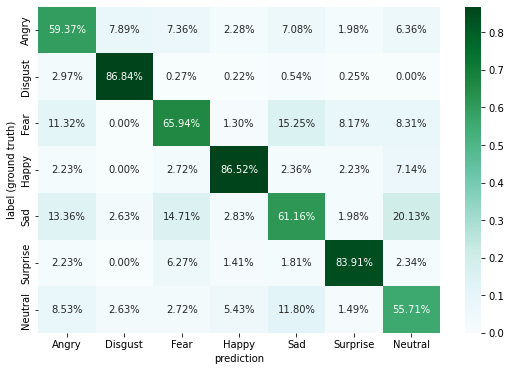

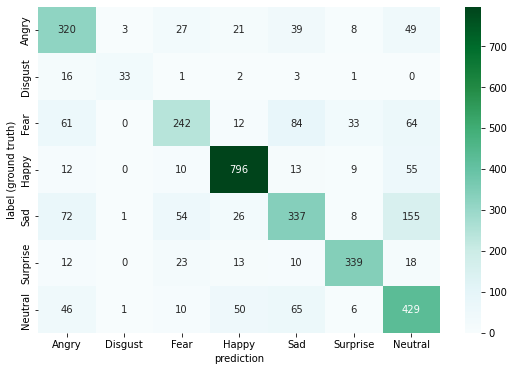



Multilabel Confusion Matrix:
 [[[2903  219]
  [ 147  320]]

 [[3528    5]
  [  23   33]]

 [[2968  125]
  [ 254  242]]

 [[2570  124]
  [  99  796]]

 [[2722  214]
  [ 316  337]]

 [[3109   65]
  [  76  339]]

 [[2641  341]
  [ 178  429]]] 

Classification report :
               precision    recall  f1-score   support

           0       0.59      0.69      0.64       467
           1       0.87      0.59      0.70        56
           2       0.66      0.49      0.56       496
           3       0.87      0.89      0.88       895
           4       0.61      0.52      0.56       653
           5       0.84      0.82      0.83       415
           6       0.56      0.71      0.62       607

    accuracy                           0.70      3589
   macro avg       0.71      0.67      0.68      3589
weighted avg       0.70      0.70      0.69      3589
 



Test Accuracy: 69.5458 %		Test Loss: 0.022303


In [59]:
evaluate_test(best, testloader, nn.CrossEntropyLoss())
print("\n")
acc_test, loss_test = evaluate(best, testloader, nn.CrossEntropyLoss())
print('Test Accuracy: %2.4f %%' % acc_test,'Test Loss: %2.6f' % loss_test,sep='\t\t')

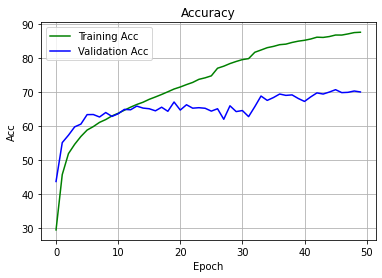

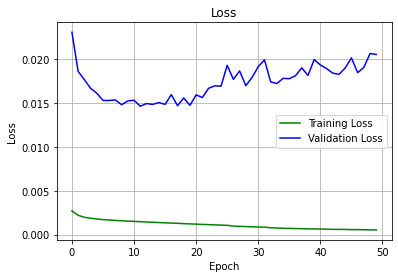

In [58]:
logger.show_plt()